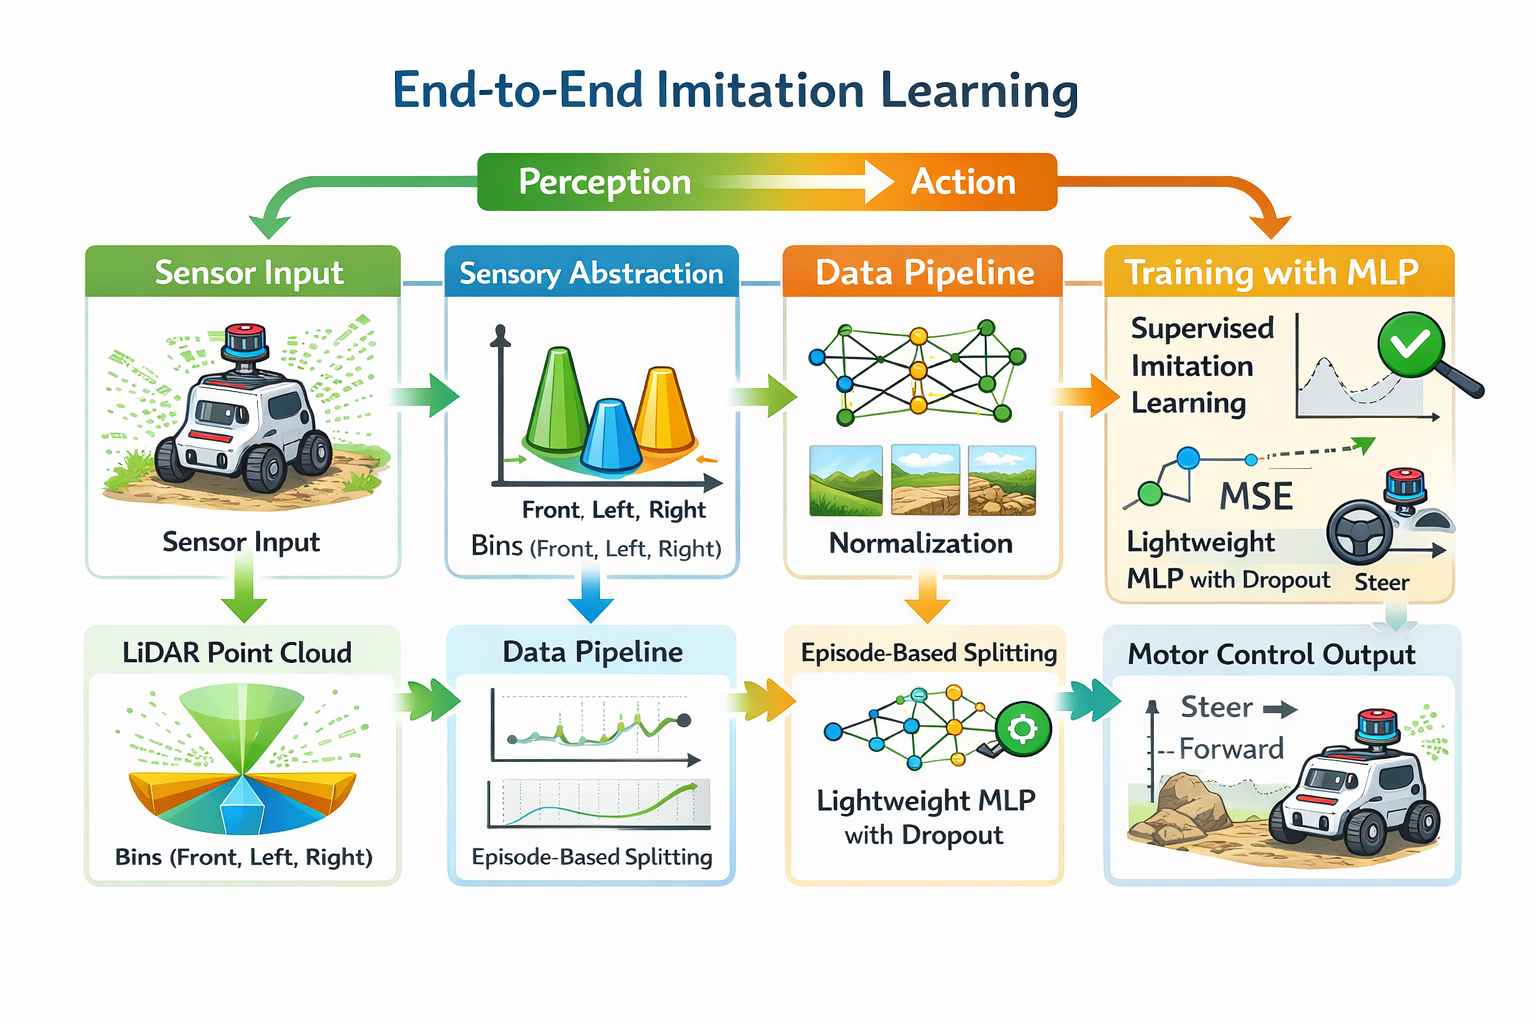
### Learning Objectives

Upon completion of this notebook, you will be able to:

* **Apply sensor abstraction techniques** by binning high-dimensional LiDAR point clouds into simplified spatial cones (Front, Left, Right) to minimize noise and computational overhead.
* **Construct a robust data pipeline** that employs normalization and episode-based splitting to prevent data leakage and ensure model generalization across varying physical terrains.
* **Design a lightweight Multilayer Perceptron (MLP)** architecture optimized for embedded deployment, incorporating Dropout regularization to maintain stability against intermittent sensor failure.
* **Implement Supervised Imitation Learning** using Mean Squared Error (MSE) to map raw environmental perception directly to continuous motor control commands (Steer/Forward).
* **Quantitatively and qualitatively validate robotic behavior** by correlating sensor inputs with predicted actions through RMSE analysis and behavior visualization.

---

### What is End-to-End Imitation Learning?

End-to-End Imitation Learning, or Behavioral Cloning, is a paradigm where a robot learns to perform a task by mimicking an "expert" agent. Instead of manually writing complex `if-then` rules for every possible obstacle configuration, the robot observes sensor data and corresponding motor actions, learning a direct mapping from **Perception** to **Action**.

This workshop focuses on bridging the "Sim-to-Real" gap using the Kaggle IRND dataset, which offers:

* **Real-World Noise Handling:** Training on physical sensor data from a wheeled robot rather than perfect, noiseless simulations.
* **Terrain Adaptability:** Learning control policies that remain consistent whether the robot is navigating on smooth floors or high-friction rough surfaces.
* **Efficient Control Mapping:** Reducing 360° LiDAR sweeps into a three-channel input that can be processed in milliseconds on low-power hardware.
* **Interpretable Robotics:** Using visualization to verify that the "reason" (a detected obstacle) leads to the correct "result" (a steering maneuver).


In [ ]:
import os
import json
import glob
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""

import kaggle

# Define the dataset identifier
dataset = "narayananpp/indoor-robot-navigation-dataset-irnd"

# Download and unzip
kaggle.api.dataset_download_files(dataset, path='./robot_data', unzip=True)

print("Dataset downloaded and extracted to ./robot_data")

## 1. Data Preparation & Engineering

The raw data consists of 276 JSON episodes recorded from a wheeled robot navigating smooth and rough surfaces.

* **Sensor Binning:** Real LiDAR provides 360+ points of depth data. We "bin" these into three virtual sensors—**Front, Left, and Right**—by taking the minimum distance within specific angular cones. This reduces high-dimensional noise while preserving critical obstacle information.
* **Normalization:** We normalize LiDAR distances (clipping at 5m) and wheel encoder counts (scaling 0–2000 to a range of -1 to 1). This ensures the neural network receives inputs and targets on a similar scale, preventing gradient explosion.
* **Data Splitting:** To ensure the model generalizes to new environments, we split the data by **episodes** (files) rather than individual time steps. This prevents "data leakage" where the model might simply memorize a specific room layout.


In [ ]:
class RobotLidarDataset(Dataset):
    def __init__(self, file_paths):
        self.inputs = []
        self.targets = []

        for file in file_paths:
            with open(file, 'r') as f:
                content = json.load(f)
                for step in content['data']:
                    # Extract LiDAR
                    angles = np.array(step['angles']) # -180 to 180
                    dists = np.array(step['dists'])

                    # Create 3-sector "virtual" sensors
                    # Front: -20 to 20 deg, Left: 70 to 110 deg, Right: -110 to -70 deg
                    f_mask = (angles > -20) & (angles < 20)
                    l_mask = (angles > 70) & (angles < 110)
                    r_mask = (angles > -110) & (angles < -70)

                    # Clean data: Replace 0.0 or Inf with a max range (5.0 meters)
                    def get_min_dist(mask):
                        vals = dists[mask]
                        vals = vals[vals > 0.1] # ignore noise very close to sensor
                        return np.min(vals) if len(vals) > 0 else 5.0

                    front = get_min_dist(f_mask)
                    left = get_min_dist(l_mask)
                    right = get_min_dist(r_mask)

                    # Normalize wheel counts (max 2000) to controls
                    # steer: [-1, 1], forward: [0, 1]
                    c_l = step['counts_left'] / 2000.0
                    c_r = step['counts_right'] / 2000.0

                    forward = (c_l + c_r) / 2.0
                    steer = c_r - c_l

                    self.inputs.append([front, left, right])
                    self.targets.append([steer, forward])

        self.inputs = np.array(self.inputs, dtype=np.float32)
        self.targets = np.array(self.targets, dtype=np.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


In [ ]:
data_files = glob.glob("./robot_data/outputs/*.json") + glob.glob("./robot_data/outputs_2/*.json")
train_files, test_files = train_test_split(data_files, test_size=0.2, random_state=42)

train_dataset = RobotLidarDataset(train_files)
test_dataset = RobotLidarDataset(test_files)


In [ ]:
print("Train Dataset Size:", len(train_dataset))
print("Test Dataset Size:", len(test_dataset))

In [ ]:
sample = train_dataset[0]
print("Sample Input:", sample[0])
print("Sample Target:", sample[1])

## Exploratory Data Analysis (EDA)

Before training the navigation models, we perform a comprehensive EDA to understand the robot's sensor distributions and control biases. This ensures the dataset contains enough variance for the model to learn effective obstacle avoidance.

---

### 1. Action & Control Distributions

We analyze the target variables—**Steer** and **Forward**—to identify potential dataset imbalances.

* **Steering Distribution:** Used to detect "Zero-Bias." If the robot drives straight 90% of the time, the model may struggle to learn recovery maneuvers when near obstacles.
* **Forward Velocity:** Visualizes the speed profile. A high density at maximum velocity indicates aggressive navigation, while a spread suggests the robot slows down during complex turns.
* **Action Density (Hexbin):** Maps the relationship between steering and speed. Typically, we expect a "V-shape" or "U-shape," where forward speed decreases as steering magnitude increases.

### 2. Sensor Input Analysis

The LiDAR data (Front, Left, and Right sectors) provides the "vision" for our model.

* **Distance Distributions (Boxplots):** We check for sensor saturation. If the sensors frequently hit the 5.0m maximum range, the model must learn to navigate in "open space" vs. "cluttered space."
* **Sensor-Action Correlation:** By plotting **Right Sensor Distance vs. Steering**, we verify if the robot's existing logic correctly steers left (positive/negative steer) when the right side is blocked.

### 3. Spatial Representation

To better understand the robot's physical perspective, we project a random sample onto a **Polar Plot**.

* **Front (0°):** Critical for emergency braking and speed control.
* **Left (90°) / Right (-90°):** Primary inputs for lateral navigation and centering.

---

### Key Dataset Statistics

| Metric | Purpose |
| --- | --- |
| **Total Samples** | Ensures the dataset is large enough for deep learning convergence. |
| **Average Forward Speed** | Baseline performance for the robot's efficiency. |
| **Straight Samples (%)** | Identifies if the dataset is over-represented by "boring" straight-line driving. |


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Prepare the data
df = pd.DataFrame(train_dataset.inputs, columns=['Front', 'Left', 'Right'])
df_targets = pd.DataFrame(train_dataset.targets, columns=['Steer', 'Forward'])
full_df = pd.concat([df, df_targets], axis=1)

# Print Summary Stats
print("--- Dataset Statistics ---")
print(f"Total Samples: {len(train_dataset)}")
print(f"Average Forward Speed: {full_df['Forward'].mean():.2f}")
print(f"Perfectly Straight Samples (%): {(full_df['Steer'] == 0).sum() / len(full_df) * 100:.1f}%")

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Steer Distribution
sns.histplot(full_df['Steer'], kde=True, color='orange', ax=ax1)
ax1.set_title("Steering Distribution\n(Check for 'Zero-Bias')")

# Forward Distribution
sns.histplot(full_df['Forward'], kde=True, color='green', ax=ax2)
ax2.set_title("Forward Velocity Distribution")

plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=full_df[['Front', 'Left', 'Right']])
plt.title("LiDAR Sector Distance Distributions")
plt.ylabel("Distance (m)")
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Sensor vs Steer Scatter
ax1.scatter(full_df['Right'], full_df['Steer'], alpha=0.1, s=1)
ax1.set_xlabel("Right Sensor Distance (m)")
ax1.set_ylabel("Steer Action")
ax1.set_title("Right Sensor vs Steering Correlation")

# Action Density Heatmap
hb = ax2.hexbin(full_df['Steer'], full_df['Forward'], gridsize=20, cmap='YlGnBu')
plt.colorbar(hb, ax=ax2, label='Count')
ax2.set_xlabel("Steer")
ax2.set_ylabel("Forward")
ax2.set_title("Action Density (Steer vs Forward)")

plt.show()

## 2. Model Architectures

We evaluate two distinct neural architectures designed for real-time obstacle avoidance and navigation.

---

### **A. Baseline: Lightweight MLP Policy**

Designed for maximum efficiency on resource-constrained embedded hardware.

* **Architecture:** A streamlined 3-layer **Multilayer Perceptron (MLP)** optimized for low-latency execution (e.g., Raspberry Pi or Jetson Nano).
* **Robustness:** Integrated **Dropout (0.2)** during training to mitigate stochastic sensor noise and prevent reliance on any single "ghost" reading.
* **Objective:** Maps 3D depth inputs () to 2D motor commands using **Mean Squared Error (MSE)** loss for continuous control.

---

### **B. Advanced: Residual Learning Policy**

Engineered for complex environments requiring higher-order feature extraction.

* **Architecture:** A deep feature extractor utilizing **Skip Connections** (Residual Blocks) to prevent signal degradation and vanishing gradients.
* **Stability:** Employs **Batch Normalization** to stabilize training across varied sensor dynamic ranges and prevent internal covariate shift.
* **Performance:** Projects raw 3D input into a **64-feature manifold**, allowing the model to negotiate complex obstacle clusters that require non-linear maneuvering.

---

### **C. Input/Output Specifications**

Both models share a unified interface for seamless deployment:

* **Input (3 Neurons):** Depth data from Front, Left, and Right sensors.
* **Output (2 Neurons):** 1.  **Steer:** Continuous value from -1 (Hard Right) to 1 (Hard Left).
2.  **Forward:** Continuous value from 0 (Stop) to 1 (Full Speed).

In [ ]:
class AvoidancePolicy(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Dropout(0.2), # Dropout helps with real-world sensor noise
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.net(x)


In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(size, size),
            nn.BatchNorm1d(size), # Stabilizes training with varied sensor ranges
            nn.ReLU(),
            nn.Linear(size, size)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        # The "Skip Connection"
        return self.relu(x + self.block(x))

class ResidualAvoidancePolicy(nn.Module):
    def __init__(self):
        super().__init__()
        # Initial projection to move from 3 sensors to 64 features
        self.input_layer = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU()
        )

        # Residual layers to process the features
        self.res_block = ResidualBlock(64)

        # Output layer for Steer and Forward
        self.output_layer = nn.Linear(64, 2)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.res_block(x)
        return self.output_layer(x)

## 3. Model Training

The training process uses **Supervised Imitation Learning**.

* **Loss Function:** We utilize **Mean Squared Error (MSE)**. The goal is to minimize the difference between the network's predicted action and the "expert" wheel counts recorded in the dataset.
* **Optimizer:** The **Adam Optimizer** is used for its adaptive learning rate, which is particularly effective when dealing with the non-stationary noise found in real-world robotics data.
* **Training Loop:** The model iterates through the dataset for 20+ epochs, adjusting internal weights to better replicate the expert's driving style on both smooth and rough terrain.


## 4. Evaluation and Visualization

Since this is a robotics project, we evaluate the model using both statistical and spatial metrics.

* **Statistical Metrics:** We calculate the **Root Mean Square Error (RMSE)** on the test set. This tells us, on average, how many "counts" off our steering predictions are compared to the human driver.
* **Action Visualizer:** We generate bar charts comparing the sensor input (the "reason") to the predicted action (the "result"). For example, if the *Front* sensor is low (close obstacle), we verify that the *Forward* command drops and the *Steer* command moves away from 0.
* **Learning Curve:** We plot the training loss vs. validation RMSE to ensure the model is converging and not overfitting to a specific surface type.

In [ ]:
# --- 2. Training Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)
criterion = nn.MSELoss()
epochs = 20

def train_model(model_class, name):
    print(f"\nTraining {name}...")
    model = model_class().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    history = {'train_loss': [], 'test_rmse': []}

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        test_err = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                test_err += torch.sum((pred - y)**2).item()

        rmse = (test_err / (len(test_dataset) * 2))**0.5
        history['train_loss'].append(total_loss / len(train_loader))
        history['test_rmse'].append(rmse)

        if epoch % 5 == 0 or epoch == epochs-1:
            print(f"Epoch {epoch:02d} | Loss: {history['train_loss'][-1]:.4f} | RMSE: {rmse:.4f}")

    return history, model

# --- 3. Execute Training ---
history_mlp, model_mlp = train_model(AvoidancePolicy, "Standard MLP")
history_res, model_res = train_model(ResidualAvoidancePolicy, "Residual Model")

# --- 4. Plotting Comparison ---
plt.figure(figsize=(10, 6))
plt.plot(history_mlp['test_rmse'], label='Standard MLP (Dropout)', color='orange', linewidth=2)
plt.plot(history_res['test_rmse'], label='Residual Model (Skip Conn + BN)', color='blue', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('RMSE Error')
plt.title('Performance Comparison: Standard MLP vs. Residual Architecture')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"\nFinal Comparison:")
print(f"Standard MLP RMSE: {history_mlp['test_rmse'][-1]:.4f}")
print(f"Residual Model RMSE: {history_res['test_rmse'][-1]:.4f}")

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import torch

def live_robot_demo(model_mlp, model_res):
    # 1. Create the UI Elements (Sliders)
    f_slider = widgets.FloatSlider(value=5.0, min=0.1, max=5.0, step=0.1, description='Front (m)')
    l_slider = widgets.FloatSlider(value=5.0, min=0.1, max=5.0, step=0.1, description='Left (m)')
    r_slider = widgets.FloatSlider(value=5.0, min=0.1, max=5.0, step=0.1, description='Right (m)')

    ui = widgets.VBox([f_slider, l_slider, r_slider])
    out = widgets.Output()

    def update_plot(change):
        with out:
            clear_output(wait=True)

            # Prepare data for the models
            f, l, r = f_slider.value, l_slider.value, r_slider.value
            in_tensor = torch.tensor([[f, l, r]], dtype=torch.float32).to(device)

            # Get predictions from BOTH models
            model_mlp.eval()
            model_res.eval()
            with torch.no_grad():
                mlp_out = model_mlp(in_tensor).cpu().numpy()[0]
                res_out = model_res(in_tensor).cpu().numpy()[0]

            # Create the Visualization
            fig, ax = plt.subplots(figsize=(8, 8))

            # Draw Lidar Beams (Front=90deg, Left=150deg, Right=30deg)
            angles = [np.pi/2, 5*np.pi/6, np.pi/6]
            dists = [f, l, r]

            for ang, d in zip(angles, dists):
                color = 'red' if d < 1.0 else 'green'
                ax.plot([0, d*np.cos(ang)], [0, d*np.sin(ang)], color=color, lw=4, alpha=0.5)
                ax.scatter(d*np.cos(ang), d*np.sin(ang), color=color, s=100)

            # Draw the Robot Body
            circle = plt.Circle((0, 0), 0.3, color='gray', alpha=0.3)
            ax.add_patch(circle)

            # DRAW DECISIONS AS ARROWS
            # Standard MLP Decision (Orange)
            # We scale the arrows by 2 for visibility
            ax.arrow(0, 0, mlp_out[0]*2, mlp_out[1]*2,
                     head_width=0.2, color='orange', alpha=0.8,
                     label=f'MLP (S: {mlp_out[0]:.2f}, F: {mlp_out[1]:.2f})')

            # Residual Model Decision (Blue)
            ax.arrow(0, 0, res_out[0]*2, res_out[1]*2,
                     head_width=0.15, color='blue', alpha=0.8,
                     label=f'Residual (S: {res_out[0]:.2f}, F: {res_out[1]:.2f})')

            # Formatting
            ax.set_xlim(-5, 5)
            ax.set_ylim(-1, 6)
            ax.set_aspect('equal')
            ax.grid(True, linestyle='--', alpha=0.4)
            ax.set_title("Model Comparison Visualizer\nBlue = Residual | Orange = MLP")
            ax.legend(loc='upper right')

            plt.show()

    # Link sliders to the function
    f_slider.observe(update_plot, names='value')
    l_slider.observe(update_plot, names='value')
    r_slider.observe(update_plot, names='value')

    display(ui, out)
    update_plot(None) # Initial render

# Run the demo using the models from your previous training step
# Make sure they are named correctly (e.g., model_mlp and model_res)
live_robot_demo(model_mlp, model_res)

## 5. Summary

This project demonstrates an **End-to-End Learning** approach where raw sensor data is mapped directly to motor commands. Using Kaggle IRND dataset, we account for real-world complexities like surface friction, sensor noise, and mechanical constraints.